In [1]:


import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp 




In [2]:

tfk = tf.keras 
tfkl = tfk.layers
tfpl = tfp.layers
tfd = tfp.distributions

# For numeric stability, set the default floating-point dtype to float64
tf.keras.backend.set_floatx('float64')




# Generate synthetic data 

In [3]:
np.random.seed(1234)

def f(x):
    return 0.5 * np.sin(15 * x) + 0.5 * x

def noise(x, slope,):
    noise_std = np.maximum(0.0, x + 1.0 ) * slope 
    return np.random.normal(0, noise_std).astype(np.float64)



    
    

In [4]:
x_train = np.linspace(-1, 1, 1000, dtype=np.float64).reshape(-1, 1)
y_train = f(x_train) + noise(x=x_train, slope=0.2, )


x_test = np.linspace(-1.5, 1.5, 200, dtype=np.float64).reshape(-1, 1)
y_test = f(x_test) + noise(x=x_test, slope=0.2, )




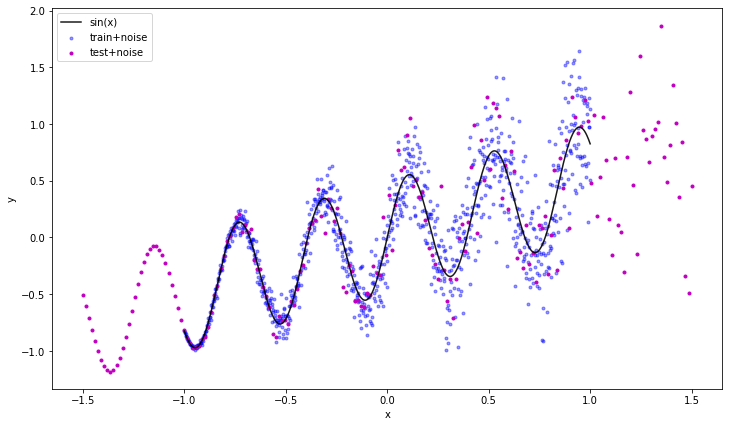

In [5]:


plt.figure(figsize=(12, 7))
plt.plot(x_train, f(x_train), color='k', marker='', alpha=0.9, label="sin(x)")
plt.scatter(x_train, y_train, color='b', marker='.', alpha=0.4, label="train+noise")
plt.scatter(x_test, y_test, color='m', marker='.', label="test+noise")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()




In [12]:
from sklearn.linear_model import LinearRegression


lr = LinearRegression().fit(x_train, y_train)

yhat_lr = lr.predict(x_test)


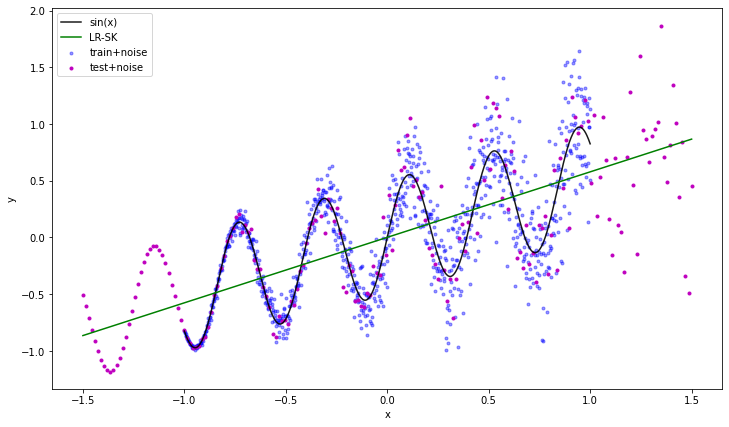

In [13]:


plt.figure(figsize=(12, 7))
plt.plot(x_train, f(x_train), color='k', marker='', alpha=0.9, label="sin(x)")
plt.scatter(x_train, y_train, color='b', marker='.', alpha=0.4, label="train+noise")
plt.scatter(x_test, y_test, color='m', marker='.', label="test+noise")
plt.plot(x_test, yhat_lr, color='g', label='LR-SK')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()



# Probabilistic regression


## modeling Aleatoric Uncertainty (Known Unknowns)

- learning a variants of data points (similar to MSE)



In [8]:
n_units = 2 
n_epochs = 1000
n_repeats = 50

In [9]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)


In [10]:
# equivalent to LR from Sklearn

mdl_al = tfk.Sequential([
    tfkl.Dense(units=n_units), 
    tfkl.Dense(1+1), 
    tfpl.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], 
                                                 
                                                 scale=1e-3+tf.math.softplus(0.05*t[..., 1:]))),
])


mdl_al.compile(loss=negloglik, optimizer=tfk.optimizers.Adam(learning_rate=1e-3))

mdl_al.fit(x=x_train, y=y_train, epochs=n_epochs, verbose=True)


yhat_al = mdl_al(x_test)





Epoch 1/1000
32/32 [==============================] - 0s 653us/step - loss: 0.7504
Epoch 2/1000
32/32 [==============================] - 0s 486us/step - loss: 0.7482
Epoch 3/1000
32/32 [==============================] - 0s 466us/step - loss: 0.7464
Epoch 4/1000
32/32 [==============================] - 0s 492us/step - loss: 0.7448
Epoch 5/1000
32/32 [==============================] - 0s 492us/step - loss: 0.7432
Epoch 6/1000
32/32 [==============================] - 0s 495us/step - loss: 0.7417
Epoch 7/1000
32/32 [==============================] - 0s 475us/step - loss: 0.7403
Epoch 8/1000
32/32 [==============================] - 0s 489us/step - loss: 0.7386
Epoch 9/1000
32/32 [==============================] - 0s 449us/step - loss: 0.7373
Epoch 10/1000
32/32 [==============================] - 0s 506us/step - loss: 0.7356
Epoch 11/1000
32/32 [==============================] - 0s 489us/step - loss: 0.7337
Epoch 12/1000
32/32 [==============================] - 0s 501us/step - loss: 0.7321
E

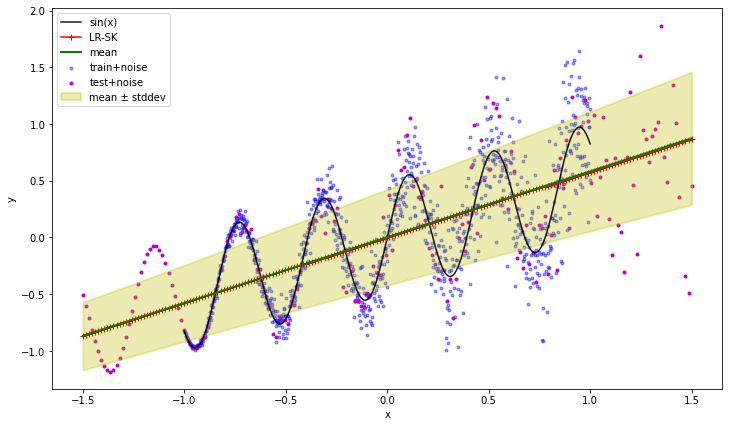

In [14]:
m_al = yhat_al.mean()[:, 0]
s_al = yhat_al.stddev()[:, 0]


plt.figure(figsize=(12, 7))
plt.plot(x_train, f(x_train), color='k', marker='', alpha=0.9, label="sin(x)")
plt.scatter(x_train, y_train, color='b', marker='.', alpha=0.4, label="train+noise")
plt.scatter(x_test, y_test, color='m', marker='.', label="test+noise")
plt.plot(x_test, yhat_lr, color='r', marker='+',  label='LR-SK')
plt.plot(x_test, m_al, color='g', marker='', linewidth=2, label=r'mean')

plt.fill_between(x_test[:, 0], m_al+s_al, m_al-s_al,
                 color='y', linewidth=2, alpha=0.3,
                 label=r'mean ± stddev')

# plt.plot(x_test, m_al - 2 * s_al, color='y', linewidth=2, label=r'mean - 2 stddev')



plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()



- red(green) line is the mean and yellow lines are stddevs. 



- Although we manage to learn some of the variations of data points, i.e., aleatoric uncertainty, now the question is: "how do we know that we have enough data?," is there "anything else we can do?", ... 

- Answer: of course, there is: why should we learn ONLY a set of weights, that is, why we should only learn the kernel and bias weight (when we use tfkl.Dense)?! We can learn a distribution over weights: by using tfp.DenseVariational instead: we learn a very large ensemble of weights called "Bayesian Weights." (thus, the weights will be random variables, RV)



## Epistemic and Aleatoric 


- We learn a very large ensemble of weights called "Bayesian Weights." (thus, the weights will be random variables, RV)


- learning variants of data points and uncertainty from the data set



In [12]:
# Specify the surrogate posterior (posterior_mean_field) over 'keras.layers.Dense', i.e., 'kernel' and 'bias':
# to learn the distributions over weights: 
# both "means" and "stddevs" are tfd.Normal trainable.


def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))    
    return tfk.Sequential([
        tfpl.VariableLayer(shape=2*n, dtype=dtype),   # weights, i.e., kernel and bias
        tfpl.DistributionLambda(lambda t: tfd.Independent(
            distribution=tfd.Normal(loc=t[..., :n], # kernel weights
                                    scale=1e-5+tf.math.softplus(c+t[..., n:])),  # bias weight
            reinterpreted_batch_ndims=1,)),
    ])



# Specify the surrogate prior over the model's weights by learning the means of tfd.Normal
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tfk.Sequential([
        tfpl.VariableLayer(n, dtype=dtype),
        tfpl.DistributionLambda(lambda t: tfd.Independent(
            distribution=tfd.Normal(loc=t, scale=1.))),
    ])
    
    
    

In [13]:
mdl_ep_al = tfk.Sequential([
    tfpl.DenseVariational(units=(1+1), 
                          make_posterior_fn=posterior_mean_field, 
                          make_prior_fn=prior_trainable, 
                          kl_weight=1/x_train.shape[1]
                         ),
    
    tfpl.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], 
                                                 scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:]))),
])


mdl_ep_al.compile(loss=negloglik, optimizer=tfk.optimizers.Adam(learning_rate=1e-2))

mdl_ep_al.fit(x=x_train, y=y_train, epochs=n_epochs, verbose=True, batch_size=32)



yhat_ep_al = mdl_ep_al(x_test)


Epoch 1/1000
32/32 [==============================] - 0s 546us/step - loss: -15.8599
Epoch 2/1000
32/32 [==============================] - 0s 496us/step - loss: -16.2691
Epoch 3/1000
32/32 [==============================] - 0s 488us/step - loss: -17.1669
Epoch 4/1000
32/32 [==============================] - 0s 494us/step - loss: -16.9740
Epoch 5/1000
32/32 [==============================] - 0s 511us/step - loss: -18.0166
Epoch 6/1000
32/32 [==============================] - 0s 519us/step - loss: -17.9897
Epoch 7/1000
32/32 [==============================] - 0s 519us/step - loss: -17.9827
Epoch 8/1000
32/32 [==============================] - 0s 514us/step - loss: -17.9709
Epoch 9/1000
32/32 [==============================] - 0s 508us/step - loss: -17.5503
Epoch 10/1000
32/32 [==============================] - 0s 515us/step - loss: -18.0606
Epoch 11/1000
32/32 [==============================] - 0s 508us/step - loss: -18.1159
Epoch 12/1000
32/32 [==============================] - 0s 509us

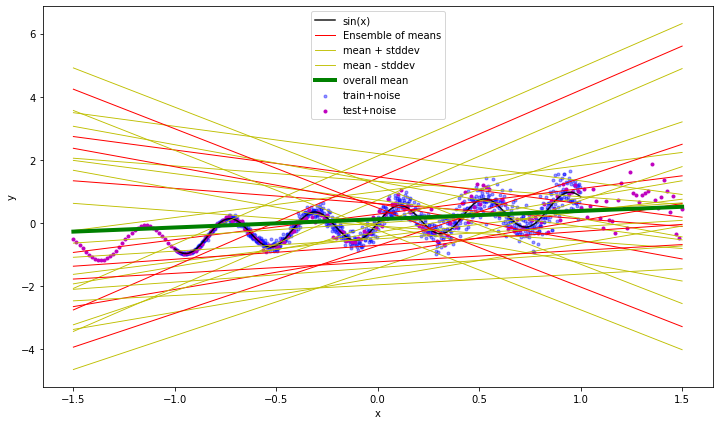

In [45]:


plt.figure(figsize=(12, 7))
plt.plot(x_train, f(x_train), color='k', marker='', alpha=0.9, label="sin(x)")
plt.scatter(x_train, y_train, color='b', marker='.', alpha=0.4, label="train+noise")
plt.scatter(x_test, y_test, color='m', marker='.', label="test+noise")


yhats_ep_al = [mdl_ep_al(x_test) for _ in range(n_repeats)]
avgm_ep_al = []

for i, yhat in enumerate(yhats_ep_al):
    
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    
    avgm_ep_al.append(m)
    plt.plot(x_test, m, 'r', linewidth=1, label='Ensemble of means' if i ==0 else None)
    plt.plot(x_test, m + s, 'y', linewidth=.9, label='mean + stddev' if i==0 else None)
    plt.plot(x_test, m - s,'y', linewidth=.9, label='mean - stddev' if i==0 else None)

    
avgm_ep_al = np.asarray(avgm_ep_al)
# avgm_ep_al = np.squeeze(avgm_ep_al)
plt.plot(x_test, avgm_ep_al.mean(axis=0), 'g', label='overall mean', linewidth=4)

plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.show()





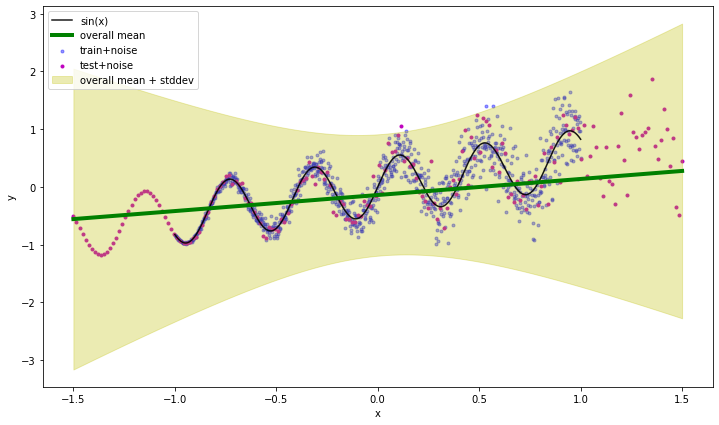

In [14]:


plt.figure(figsize=(12, 7))
plt.plot(x_train, f(x_train), color='k', marker='', alpha=0.9, label="sin(x)")
plt.scatter(x_train, y_train, color='b', marker='.', alpha=0.4, label="train+noise")
plt.scatter(x_test, y_test, color='m', marker='.', label="test+noise")


yhats_ep_al = [mdl_ep_al(x_test) for _ in range(n_repeats)]
avgm_ep_al = []

for i, yhat in enumerate(yhats_ep_al):
    avgm_ep_al.append(yhat.mean())

    
avgm_ep_al = np.asarray(avgm_ep_al)
avgm_ep_al = np.squeeze(avgm_ep_al)

plt.plot(x_test, avgm_ep_al.mean(axis=0), 'g', label='overall mean', linewidth=4)
plt.fill_between(x_test[:, 0], 
                 avgm_ep_al.mean(axis=0) + avgm_ep_al.std(axis=0), 
                 avgm_ep_al.mean(axis=0) - avgm_ep_al.std(axis=0),
                 label='overall mean + stddev', 
                 linewidth=.9, color='y', alpha=0.3)




# plt.plot(x_test, avgm_ep_al.mean(axis=0) + avgm_ep_al.std(axis=0), 'y', 
#          label='overall mean + stddev', linewidth=.9)
# plt.plot(x_test, avgm_ep_al.mean(axis=0) - avgm_ep_al.std(axis=0), 'y', 
#          label='overall mean - stddev', linewidth=.9)


plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.show()






- Not only we model the data but also we determine the variety of data points (aleatoric) and epistemic uncertainty.

- The high standard deviation of various draws of weights, or considering the previous plots, show that the adopted linear model could not be proper choice to model our data set.

- Now the question is, what make us think that a line should represent data?!

    - What if we do not know the functional relationship between the inputs and the labels?
    - Why not to use a richer distribution to fit our data?! 

- (Variational) Gaussian Process is the solution. More so, VGP treats the loss_fn as RV too.









## Functional dependencies (VGP)

In [6]:
class RBFKernelFn(tfkl.Layer):
    
    def __init__(self, **kwargs):
        super(RBFKernelFn, self).__init__(**kwargs)
        
        dtype = kwargs.get('dtype', None)
        
        self._amplitude = self.add_weight(
        initializer=tf.constant_initializer(0), 
        dtype=dtype, 
        name='amplitude')
        
        self._length_scale = self.add_weight(
        initializer=tf.constant_initializer(0), 
        dtype=dtype, 
        name="length_scale")
        
    def call(self, x):
        # never will be called: 
        # it just holds the data so that Keras will understand
        return x 
    
    @property
    def kernel(self):
        return tfp.math.psd_kernels.ExponentiatedQuadratic(
            amplitude=tf.nn.softplus(0.1 * self._amplitude),
            length_scale=tf.nn.softplus(5. * self._length_scale),
        )
        

In [7]:
x_range = [-1, +1]

# Build model_vgp.
num_inducing_points = 40

mdl_vgp = tfk.Sequential([
    tfkl.InputLayer(input_shape=[1,]),
    tfkl.Dense(units=n_units),  # hidden layer units
    tfkl.Dense(2),  # target layer units
    tfpl.VariationalGaussianProcess(num_inducing_points=num_inducing_points, 
                                    kernel_provider=RBFKernelFn(), 
                                    event_shape=[1,], 
                                    inducing_index_points_initializer=tf.constant_initializer(
                                        np.linspace(*x_range, num=num_inducing_points,
                                                    dtype=x_train.dtype)[..., np.newaxis]),
                                    unconstrained_observation_noise_variance_initializer=(
                                        tf.constant_initializer(np.array(0.54).astype(x_train.dtype))),
                                   ),
])



loss = lambda y, rv_y: rv_y.variational_loss(y, kl_weight=np.array(batch_size, x_train.dtype) / x_train.shape[0])

batch_size = 32
mdl_vgp.compile(loss=loss, optimizer=tfk.optimizers.Adam(1e-3))

hst_vgp = mdl_vgp.fit(x=x_train, y=y_train, epochs=n_epochs, verbose=True, )


yhat_vgp = mdl_vgp(x_test)




NameError: name 'n_units' is not defined

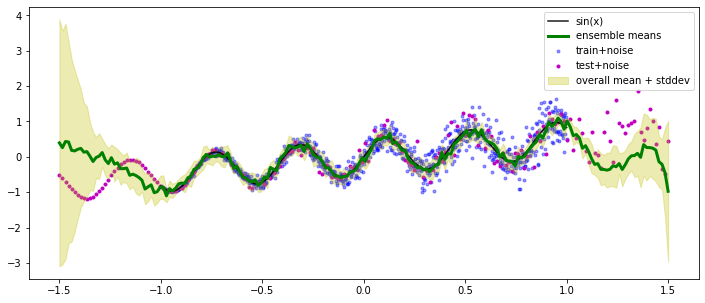

In [24]:


plt.figure(figsize=(12, 5))
plt.plot(x_train, f(x_train), color='k', marker='', alpha=0.9, label="sin(x)")
plt.scatter(x_train, y_train, color='b', marker='.', alpha=0.4, label="train+noise")
plt.scatter(x_test, y_test, color='m', marker='.', label="test+noise")

n_repeats = 10
samples_vgp = []

for i in range(n_repeats):
    samples_vgp.append(yhat_vgp.sample().numpy())

samples_vgp = np.asarray(samples_vgp)
if n_repeats > 1:
    samples_vgp = np.squeeze(samples_vgp)

plt.plot(x_test, samples_vgp.mean(axis=0), 'g', linewidth=3, label='ensemble means');

plt.fill_between(x_test[:, 0], 
                 samples_vgp.mean(axis=0) + samples_vgp.std(axis=0),
                 samples_vgp.mean(axis=0) - samples_vgp.std(axis=0),
                 color='y', linewidth=1, alpha=0.3, label='overall mean + stddev');


plt.legend()
plt.show()


- With this model we treat the weights, and the loss both as a random variables and we managed to fit the model 
properly to the data.

- However, it seems that the model is overfitted and this should be address/considered in a real-world problem.

